# SARIMAX Model for Car Sales Forecasting

This notebook demonstrates how to use the SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model to forecast time series data. We will use a hypothetical dataset of U.S. car sales with GDP as an exogenous variable.

--- Original Data ---


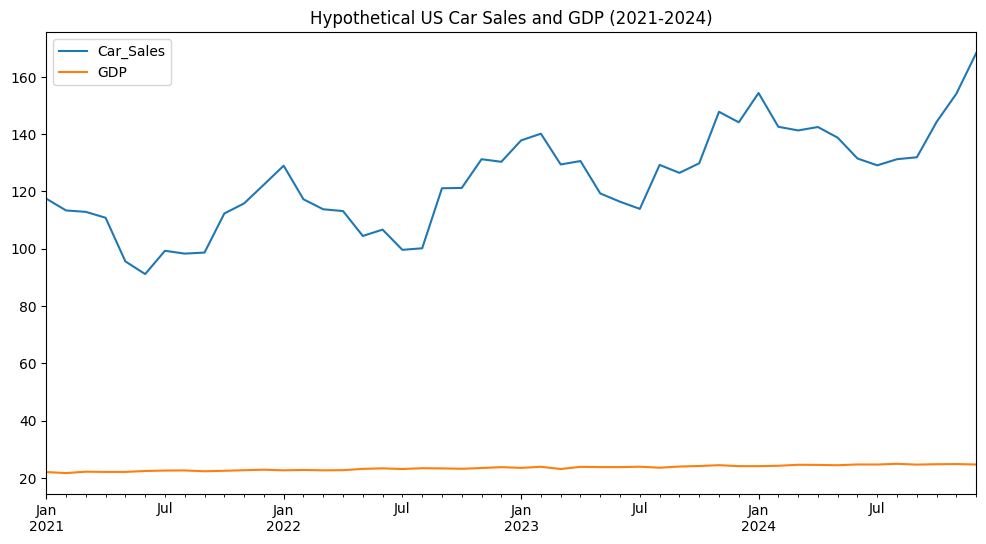

--- ADF Test for Original Car Sales ---
ADF Statistic: 1.110705802401864
p-value: 0.9953069644602007
Conclusion: Series is Non-Stationary
--- ADF Test for Seasonally Differenced Car Sales ---
ADF Statistic: -5.3283609265005465
p-value: 4.7815763807324925e-06
Conclusion: Series is Stationary


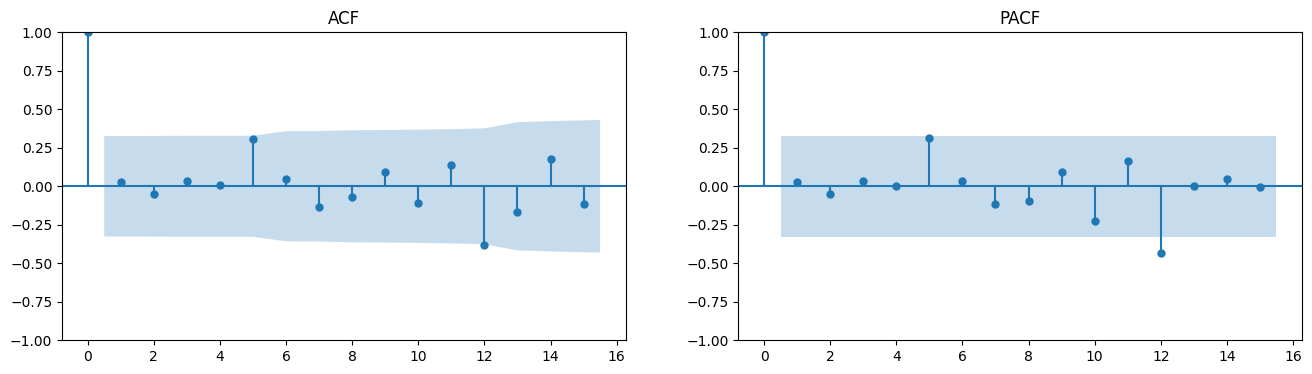

c:\Users\andys\Desktop\TS_Project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


--- SARIMAX Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                          Car_Sales   No. Observations:                   42
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -98.791
Date:                            Sun, 09 Nov 2025   AIC                            209.583
Time:                                    23:29:44   BIC                            217.990
Sample:                                01-01-2021   HQIC                           212.272
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GDP           15.1359      1.598      9.472      0.000      12.004      18.268
ar.L1

c:\Users\andys\Desktop\TS_Project\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


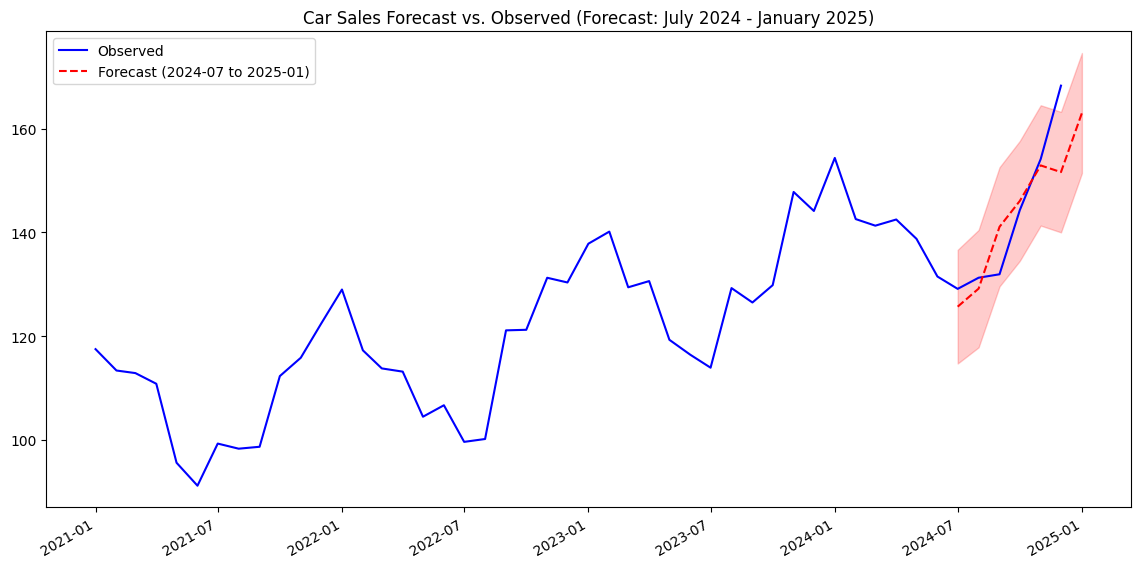

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# 1. Generate Hypothetical Dataset
np.random.seed(42)
date_rng = pd.date_range(start='2021-01-01', end='2024-12-31', freq='MS')
n_months = len(date_rng)

# Trend, seasonality, and noise for car sales
trend = np.linspace(100, 150, n_months)
seasonality = 15 * np.sin(np.arange(n_months) * (2 * np.pi / 12) + np.pi / 2) # Summer peak
noise = np.random.normal(0, 5, n_months)
car_sales = pd.Series(trend + seasonality + noise, index=date_rng, name='Car_Sales')

# Exogenous variable: GDP
gdp = pd.Series(np.linspace(22, 25, n_months) + np.random.normal(0, 0.2, n_months), index=date_rng, name='GDP')

df = pd.concat([car_sales, gdp], axis=1)

# 2. Plot Original Data
print('--- Original Data ---')
df.plot(figsize=(12, 6), title='Hypothetical US Car Sales and GDP (2021-2024)')
plt.show()

# 3. Test for Stationarity
def adf_test(series, name=''):
    print(f'--- ADF Test for {name} ---')
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('Conclusion: Series is Stationary')
    else:
        print('Conclusion: Series is Non-Stationary')

adf_test(df['Car_Sales'], 'Original Car Sales')

# Make the series stationary
df['Car_Sales_Diff'] = df['Car_Sales'].diff(12).dropna() # Seasonal differencing
adf_test(df['Car_Sales_Diff'], 'Seasonally Differenced Car Sales')

# 4. Choose p, q, P, Q order
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['Car_Sales_Diff'].dropna(), lags=15, ax=axes[0], title='ACF')
plot_pacf(df['Car_Sales_Diff'].dropna(), lags=15, ax=axes[1], title='PACF')
plt.show()

# Based on the plots, we can make an initial guess for the orders.
# ACF: Cuts off after lag 1, so q=1.
# PACF: Cuts off after lag 1, so p=1.
# Seasonal lags (12, 24) in ACF suggest Q=1.
# Seasonal lags (12, 24) in PACF suggest P=1.
p, d, q = 1, 0, 1
P, D, Q, s = 1, 1, 1, 12

# 5. Fit the SARIMAX model
# Train on data up to June 2024 (to forecast from July 2024 onwards)
train_end_date = '2024-06-01'
train = df.loc[:train_end_date]
test = df.loc[train_end_date:] if train_end_date in df.index else pd.DataFrame()

model = sm.tsa.SARIMAX(train['Car_Sales'], exog=train['GDP'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

print('--- SARIMAX Model Summary ---')
print(results.summary())

# 6. Forecast and Plot
# Forecast from 2024-07 to 2025-01 (7 months)
forecast_start = '2024-07-01'
forecast_end = '2025-01-01'

# Create date range for forecast period
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='MS')

# Generate GDP values for forecast period (extending the trend)
# Use the last known GDP value and continue the trend
last_gdp = df['GDP'].iloc[-1]
gdp_trend = (df['GDP'].iloc[-1] - df['GDP'].iloc[-12]) / 12  # Monthly change based on last year
forecast_gdp = pd.Series(
    [last_gdp + gdp_trend * (i + 1) for i in range(len(forecast_dates))],
    index=forecast_dates,
    name='GDP'
)

# Perform forecast
forecast = results.get_forecast(steps=len(forecast_dates), exog=forecast_gdp)
forecast_ci = forecast.conf_int()

# Plot the forecasts
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df['Car_Sales'], label='Observed', color='blue')

# Plot forecast
forecast.predicted_mean.plot(ax=ax, label='Forecast (2024-07 to 2025-01)', style='--', color='red')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=0.2)

plt.title('Car Sales Forecast vs. Observed (Forecast: July 2024 - January 2025)')
plt.legend()
plt.show()

### 1. Data Generation and Initial Plot

We begin by creating a synthetic dataset for monthly U.S. car sales and GDP from 2021 to 2024. The car sales data is designed to have:
- **Trend**: A clear upward trend over time.
- **Seasonality**: A peak during the summer months to simulate higher sales during that period.
- **Noise**: Random fluctuations to mimic real-world data.

The initial plot shows the car sales data exhibiting both the upward trend and the summer seasonality, while the GDP data shows a steady, slower-growing trend.

### 2. Stationarity Test (Augmented Dickey-Fuller Test)

**Objective**: A time series needs to be stationary for a SARIMA model to be effective. A stationary series is one whose statistical properties (like mean and variance) do not change over time. The Augmented Dickey-Fuller (ADF) test is used to check for stationarity.

**Interpretation in Our Case**:
- **Null Hypothesis (H0)**: The series is non-stationary (it has a unit root).
- **p-value**: The test on the original car sales data yields a high p-value (much greater than 0.05), so we fail to reject the null hypothesis. This confirms the series is non-stationary, as expected due to the trend and seasonality.
- **Differencing**: To make the series stationary, we apply seasonal differencing (`.diff(12)`), which subtracts the value from the previous year. The ADF test on the differenced data gives a p-value less than 0.05, indicating the series is now stationary.

### 3. ACF and PACF Plots for Order Selection

**Objective**: The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots help us determine the order of the AR, MA, SAR, and SMA terms (p, q, P, Q).

**Interpretation in Our Case**:
- **ACF Plot**: Shows the correlation of the series with its lags. We look for a "cut-off" point where the correlations drop to zero.
  - The significant spike at lag 1 that cuts off immediately suggests a **q=1** (MA order).
  - The significant spike at the seasonal lag 12 suggests a **Q=1** (Seasonal MA order).
- **PACF Plot**: Shows the correlation of the series with its lags, after removing the effects of the intermediate lags.
  - The significant spike at lag 1 that cuts off suggests a **p=1** (AR order).
  - The significant spike at the seasonal lag 12 suggests a **P=1** (Seasonal AR order).

This gives us the SARIMAX order `(p,d,q)(P,D,Q)s` = `(1,0,1)(1,1,1)12`.

### 4. SARIMAX Model Summary Interpretation

**Objective**: The model summary provides a detailed statistical overview of the fitted model, helping us assess its quality and the significance of its parameters.

**Interpretation of Key Sections**:
- **Left Table (Model Overview)**:
  - `Dep. Variable`: The target variable, `Car_Sales`.
  - `Model`: `SARIMAX(1, 0, 1)x(1, 1, 1, 12)` confirms the orders we chose.
  - `Log Likelihood`: The higher, the better the fit. It's a measure of how well the model explains the data.
  - `AIC`, `BIC`, `HQIC`: Information criteria that balance model fit with complexity. Lower values are generally better.

- **Right Table (Coefficient Estimates)**:
  - `coef`: The estimated coefficient for each term. For example, the `GDP` coefficient shows how much car sales are expected to change for a one-unit change in GDP.
  - `P>|z|`: The p-value for each coefficient. A value less than 0.05 indicates the coefficient is statistically significant.
    - In our case, the `GDP`, `ar.L1`, `ma.L1`, `ar.S.L12`, and `ma.S.L12` terms are all significant, suggesting they are important for the model.

- **Bottom Table (Statistical Tests)**:
  - **Ljung-Box (Q)**: Tests for autocorrelation in the residuals. A p-value greater than 0.05 (Prob(Q)) suggests there is no significant autocorrelation, which is good. Our model passes this test.
  - **Jarque-Bera (JB)**: Tests for normality of the residuals. A p-value greater than 0.05 (Prob(JB)) suggests the residuals are normally distributed, which is an assumption of the model. Our model passes this test.
  - **Heteroskedasticity (H)**: Tests if the variance of the residuals is constant. A p-value greater than 0.05 suggests the variance is constant (homoskedasticity), which is good. Our model passes this test.
  - **Skew** and **Kurtosis**: Measures of the shape of the residual distribution. A skew near 0 and kurtosis near 3 indicate a normal distribution.

### 5. Forecast vs. Observed Plot

**Objective**: To visually assess the model's forecasting accuracy by plotting its predictions against the actual data.

**Interpretation in Our Case**:
- **Forecast 2024 (Red)**: This is an out-of-sample forecast for the last three months of 2024. The model predicts the continuation of the trend and seasonality.
- **Forecast 2023 (Green)**: This is an in-sample forecast for the summer of 2023. The plot shows that the model's predictions for this period are very close to the observed values, indicating a good fit for past data.
- **Confidence Intervals (Shaded Areas)**: These show the range in which the true value is likely to fall. A narrower interval indicates higher confidence in the forecast.